# Estimation of correction matrices for chromatic aberration
Last update: 2021-01-11 <br>
version 1.0.1

Code under GNU General Public License v3 (see `LICENSE` file). <br>
Contact: A. Coulon antoine.coulon@curie.fr – Institut Curie, CNRS. 2022

In [1]:
###########
dirSrc='../'
dirDropbox='/Users/acoulon/CoulonLab/'
###########

from scipy import *
from scipy import optimize
from matplotlib import pyplot as plt, ticker
import os, sys, warnings, imp

if not os.path.exists(dirSrc):     warnings.warn("Could not locate source code directory.")
if not os.path.exists(dirDropbox): warnings.warn("Could not locate Dropbox directory.")

sys.path.append(dirSrc)
import locFiles as lf

## 1. Choose data set

In [96]:
###########

#dirData=dirDropbox+'data/Antoine/20190808/chromaticCorrAnalysis/20190808_tetraSpecBeads-1um_zStack_allChannels_1'
#dirData=dirDropbox+'data/Maciej/2020/20201102_beads/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1'
#dirData=dirDropbox+'data/Antoine/20210104/20210104_tests-new-SpectraX-NIR_beads_muliPos_1'

dirData=dirDropbox+'data/Antoine/20210104/20210104_microscope1_test-SpectraX_beads_multiPos_1'
dirData=dirDropbox+'data/Antoine/20210104/20210104_microscope1_test-SpectraX_beads_multiPos_4band_1'

###########

dirOut=os.path.join(dirData,'out/')
dataSetName=os.path.basename(dirData)

if not os.path.exists(dirData):    warnings.warn("Could not locate data directory.")
if not os.path.exists(dirOut):     warnings.warn("Could not locate processed data directory.")


If needed, concatenante `.loc` files:

In [100]:
#suff='_o5-AF750.loc'
#suff='_o5-Q670.loc'
#suff='_o5-CAL610.loc'
#suff='_o5-Q570.loc'
#suff='_GFP.loc'
#suff='_DAPI.loc'

suff='_4band-iRFP.loc'
#suff='_4band-mRuby.loc'
#suff='_4band-GFP.loc'
#suff='_4band-BFP.loc'

savetxt(dirOut+dataSetName+suff,
    concatenate([(lambda d: c_[d,ones((d.shape[0],2))*i].reshape(-1,10))(loadtxt(dirOut+fn,skiprows=1))
                 for i,fn in enumerate([fn for fn in sort(os.listdir(dirOut)) if ('_Pos' in fn) and (suff in fn)])]),
    fmt='%.5e',header="# cols: intensity, x pos, y pos, z pos, bg offset, bg x tilt, bg y tilt, bg z tilt, field, field")


## 2. Load data and adjust `distCutoff` to select pairs that should colocalize

/Users/acoulon/CoulonLab/data/Antoine/20210104/20210104_microscope1_test-SpectraX_beads_multiPos_4band_1/out/20210104_microscope1_test-SpectraX_beads_multiPos_4band_1_4band-mRuby.loc


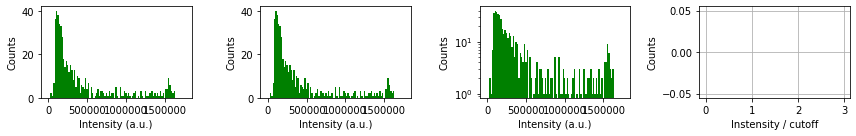

/Users/acoulon/CoulonLab/data/Antoine/20210104/20210104_microscope1_test-SpectraX_beads_multiPos_4band_1/out/20210104_microscope1_test-SpectraX_beads_multiPos_4band_1_4band-BFP.loc


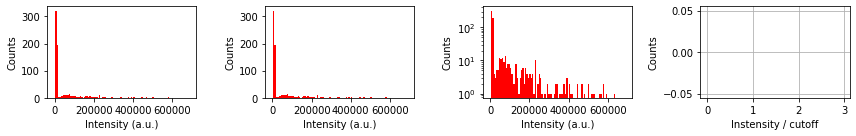

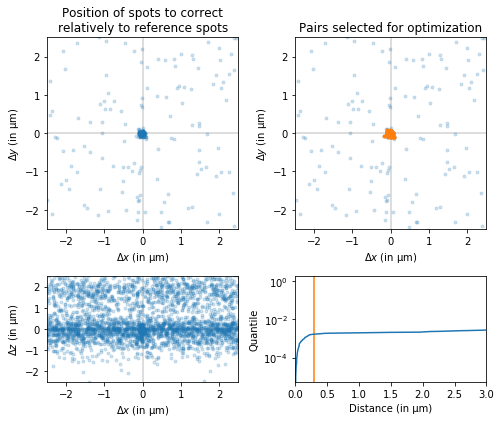

Selected 170 pairs out of 102148.


In [112]:
############

#data_ref       =lf.loadLoc2(dirOut+dataSetName+'_o5-Q570.loc',cutoffLow=1e0,disp=1,color='green')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_o5-AF750.loc',cutoffLow=1e0,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_o5-Q670.loc',cutoffLow=1e0,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_o5-CAL610.loc',cutoffLow=1e0,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_GFP.loc',cutoffLow=1e0,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_DAPI.loc',cutoffLow=1e0,disp=1,color='red')

#data_ref       =lf.loadLoc2(dirOut+dataSetName+'_mRuby.loc',cutoffLow=0e5,disp=1,color='green')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_iRFP.loc',cutoffLow=0e5,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_GFP.loc',cutoffLow=0e5,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_BFP.loc',cutoffLow=0e0,disp=1,color='red')

data_ref       =lf.loadLoc2(dirOut+dataSetName+'_4band-mRuby.loc',cutoffLow=0e5,disp=1,color='green')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_4band-iRFP.loc',cutoffLow=0e5,disp=1,color='red')
#data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_4band-GFP.loc',cutoffLow=0e5,disp=1,color='red')
data_to_correct=lf.loadLoc2(dirOut+dataSetName+'_4band-BFP.loc',cutoffLow=0e0,disp=1,color='red')

if 0: # Restrict analysis to a single field of view
    fieldId=0
    data_ref       =data_ref       [where(data_ref       [:,-2]==fieldId)]
    data_to_correct=data_to_correct[where(data_to_correct[:,-2]==fieldId)]

distCutoff=.3

rangeXY=2.5
rangeZ =2.5

############

d0=data_ref
d1=data_to_correct

fnParams=os.path.join(dirData,'params.py')
if os.path.isfile(fnParams):
    prm=imp.load_source('prm',fnParams)
    voxelSize=r_[prm.pxSize,prm.pxSize,prm.zStep]
else:
    voxelSize=r_[.1075,.1075,.3]
    print(" /!\ Warning, voxel size not provided. Using default values (%s)"%repr(voxelSize))

def calc_relPos(d0,d1):
    i0=0; i1=0; i1_start=0;
    relPos=[]
    for frame in range(int(d0[:,-2].max())+1):
        i1_start=i1
        while i0<d0.shape[0] and d0[i0,-2]<=frame:
            i1=i1_start
            while i1<d1.shape[0] and d1[i1,-2]<=frame:
                relPos.append((d0[i0,1:4]-d1[i1,1:4])*voxelSize)
                relPos[-1]=r_[relPos[-1],sum(relPos[-1]**2)**.5,i0,i1]
                i1+=1
            i0+=1
    return array(relPos) #Columns are: delta x, delta y, delta z, distance, i0, i1

relPos=calc_relPos(d0,d1)
relPos_sel=relPos[where(relPos[:,3]<distCutoff)[0]]

fig,ax=plt.subplots(2,2,sharex=False,sharey=False,figsize=(7,6),gridspec_kw={'height_ratios':[2,1]});

ax_=ax[0,0]
ax_.set_title('Position of spots to correct\nrelatively to reference spots')
ax_.scatter(relPos[:,0],relPos[:,1],marker='.',alpha=.2)
ax_.set_aspect('equal'); ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)
ax_.set_xlabel('$\\Delta x$ (in µm)'); ax_.set_ylabel('$\\Delta y$ (in µm)');
ax_.set_xlim(-rangeXY,rangeXY); ax_.set_ylim(-rangeXY,rangeXY);

ax_=ax[1,0]
ax_.scatter(relPos[:,0],relPos[:,2],marker='.',alpha=.2)
ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)
ax_.set_xlabel('$\\Delta x$ (in µm)'); ax_.set_ylabel('$\\Delta z$ (in µm)');
ax_.set_xlim(-rangeXY,rangeXY); ax_.set_ylim(-rangeZ,rangeZ);

ax_=ax[0,1]
ax_.set_title('Pairs selected for optimization')
ax_.scatter(relPos[:,0],relPos[:,1],marker='.',alpha=.2)
ax_.scatter(relPos_sel[:,0],relPos_sel[:,1],marker='.',alpha=1,c='C01')
ax_.set_xlabel('$\\Delta x$ (in µm)'); ax_.set_ylabel('$\\Delta y$ (in µm)');
ax_.set_aspect('equal'); ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)
ax_.set_xlim(-rangeXY,rangeXY); ax_.set_ylim(-rangeXY,rangeXY);

ax_=ax[1,1]
ax_.axvline(distCutoff,c='C01')
ax_.plot(sort(relPos[:,3]),r_[0:1:1j*relPos.shape[0]])
ax_.set_xlim(0,3); #ax_.set_ylim(0,.1)
ax_.set_yscale('log')
ax_.set_xlabel('Distance (in µm)'); ax_.set_ylabel('Quantile');

plt.tight_layout()
plt.show()

print("Selected %d pairs out of %d."%(relPos_sel.shape[0],relPos.shape[0]))


## 3. Perform fit and inspect visually that spots are better colocalized

Fit correction matrix parameters

In [113]:
def M_fullMatrix(p):
    return r_[p,0,0,0,1].reshape((4,4))

def M_scaleAroundXYpoint_shiftZ(p):
    return r_[p[0], 0,    0,    p[1]*(1-p[0]),
              0,    p[0], 0,    p[2]*(1-p[0]),
              0,    0,    1,    p[3]         ,
              0,    0,    0,    1             ].reshape((4,4))

def toOpt_M(M):
    d1Corr=lf.chromaticCorrData(d1,M)
    dist=array([sum(((d0[i0,1:4]-d1Corr[i1,1:4])*voxelSize)**2)**.5 for i0,i1 in relPos_sel[:,-2:].astype(int)])
    return mean(dist)
    #return mean(dist**2)

#toOpt=lambda p: toOpt_M(M_fullMatrix(p))
#fit=optimize.fmin(toOpt,r_[1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 0,],maxiter=1e4)
toOpt=lambda p: toOpt_M(M_scaleAroundXYpoint_shiftZ(p))
#fit=optimize.fmin(toOpt,r_[1,1000,1000,-5.63218310e+00],maxiter=20000)
fit=optimize.fmin(toOpt,r_[1,500,500,0],maxiter=1e4)

M=M_scaleAroundXYpoint_shiftZ(fit)
relPosCorr=calc_relPos(d0,lf.chromaticCorrData(d1,M))

print("Fit result:",fit)

Optimization terminated successfully.
         Current function value: 0.107989
         Iterations: 221
         Function evaluations: 384
Fit result: [ 9.99294954e-01  2.33150820e+02  3.48213228e+02 -1.23667947e-01]


–OR– use matrix:

In [114]:
# M=array(   [1.0008169, 0, 0, -1.0308455, 0, 1.0008169, 0, -2.0439162, 0, 0, 1, -0.041555888, 0, 0, 0, 1]   ).reshape(4,4)
#M=M_scaleAroundXYpoint_shiftZ(r_[1.0005,0,0,0])

#relPosCorr=calc_relPos(d0,lf.chromaticCorrData(d1,M))

Display results

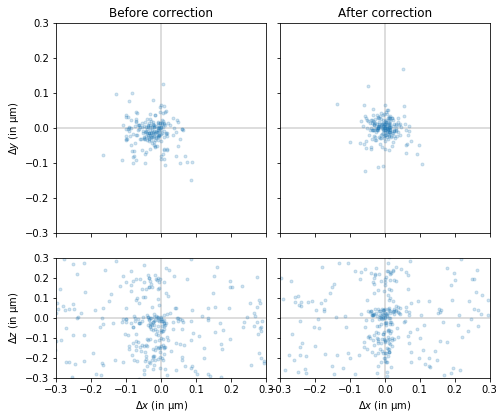

Localization error: ∆xy = 0.030µm
                    ∆z  = 0.078µm

chromaticCorrM = [0.99929495, 0, 0, 0.16438202, 0, 0.99929495, 0, 0.24550629, 0, 0, 1, -0.12366795, 0, 0, 0, 1]


In [115]:
rangeXY=.3
rangeZ =.3

############

fig,ax=plt.subplots(2,2,sharex=True,sharey=True,figsize=(7,6),gridspec_kw={'height_ratios':[2,1]});

ax_=ax[0,0]
ax_.set_title('Before correction')
ax_.scatter(relPos[:,0],relPos[:,1],marker='.',alpha=.2)
ax_.set_aspect('equal'); ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)
ax_.set_ylabel('$\\Delta y$ (in µm)');
ax_.set_xlim(-rangeXY,rangeXY); ax_.set_ylim(-rangeXY,rangeXY);

ax_=ax[1,0]
ax_.scatter(relPos[:,0],relPos[:,2],marker='.',alpha=.2)
ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)
ax_.set_xlabel('$\\Delta x$ (in µm)'); ax_.set_ylabel('$\\Delta z$ (in µm)');
ax_.set_xlim(-rangeXY,rangeXY); ax_.set_ylim(-rangeZ,rangeZ);

ax_=ax[0,1]
ax_.set_title('After correction')
ax_.scatter(relPosCorr[:,0],relPosCorr[:,1],marker='.',alpha=.2)
ax_.set_aspect('equal'); ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)

ax_=ax[1,1]
ax_.scatter(relPosCorr[:,0],relPosCorr[:,2],marker='.',alpha=.2)
ax_.axvline(0,c='lightgray',zorder=0); ax_.axhline(0,c='lightgray',zorder=0)
ax_.set_xlabel('$\\Delta x$ (in µm)');

plt.tight_layout()
plt.show()

locErrorXY=median([sum(rp[:2]**2)**.5 for rp in relPosCorr[where(relPosCorr[:,-3]<distCutoff)]])
locErrorZ= median([abs(rp[2])         for rp in relPosCorr[where(relPosCorr[:,-3]<distCutoff)]])
print("Localization error: ∆xy = %.3fµm"%locErrorXY)
print("                    ∆z  = %.3fµm"%locErrorZ)
print('')
print('===================')
print('chromaticCorrM = ['+', '.join(['%.8g'%a for a in M.flatten()])+']')
print('===================')


The `chromaticCorrM` variable above is what should be passed to `loadLoc2()`.



In [ ]:
# 2021/01/11. From data/Antoine/20210104

chromaticCorrMatrices={
  'microscope1_100x_dz0.3um':{
    'iRFP => mRuby':  [1.0022099, 0, 0, -0.81455137, 0, 1.0022099, 0, -1.3634379, 0, 0, 1, 0.071712474, 0, 0, 0, 1],
    'mRuby => mRuby': [1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0],
    'GFP => mRuby':   [0.99826896, 0, 0, 0.83427448, 0, 0.99826896, 0, 0.17904799, 0, 0, 1, 0.017091257, 0, 0, 0, 1],
    'BFP => mRuby':   [0.9989992, 0, 0, 0.00014805315, 0, 0.9989992, 0, 0.00013141322, 0, 0, 1, -0.14055083, 0, 0, 0, 1],

    '4band-iRFP => 4band-mRuby':  [1.0017792, 0, 0, -0.76361439, 0, 1.0017792, 0, -0.73552239, 0, 0, 1, 0.078497219, 0, 0, 0, 1],
    '4band-mRuby => 4band-mRuby': [1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0],
    '4band-GFP => 4band-mRuby':   [0.99928269, 0, 0, 0.27378302, 0, 0.99928269, 0, 0.29157278, 0, 0, 1, -0.010219592, 0, 0, 0, 1], 
    '4band-BFP => 4band-mRuby':   [0.99929495, 0, 0, 0.16438202, 0, 0.99929495, 0, 0.24550629, 0, 0, 1, -0.12366795, 0, 0, 0, 1],
  }
}

### Co-localization errors:
#    'iRFP => mRuby':    ∆xy = 0.048µm   ∆z  = 0.054µm
#    'mRuby => mRuby':   reference
#    'GFP => mRuby':     ∆xy = 0.041µm   ∆z  = 0.055µm
#    'BFP => mRuby':     ∆xy = 0.059µm   ∆z  = 0.086µm

#    '4band-iRFP => 4band-mRuby':   ∆xy = 0.030µm   ∆z  = 0.057µm
#    '4band-mRuby => 4band-mRuby':  reference
#    '4band-GFP => 4band-mRuby':    ∆xy = 0.028µm   ∆z  = 0.053µm
#    '4band-BFP => 4band-mRuby':    ∆xy = 0.030µm   ∆z  = 0.078µm


In [ ]:
# 2021/01/11. From data/Antoine/20210104

chromaticCorrMatrices={
  'microscope2_60x_dz0.3um':{
    'o5-AF750 => o5-Q570':  [1.0035272, 0, 0, -3.8622715, 0, 1.0035272, 0, -6.4048422, 0, 0, 1, -0.10315332, 0, 0, 0, 1],
    'o5-Q670 => o5-Q570':   [1.0020434, 0, 0, -2.7515097, 0, 1.0020434, 0, 1.4150367, 0, 0, 1, 0.050288204, 0, 0, 0, 1],
    'o5-CAL610 => o5-Q570': [1.0008169, 0, 0, -1.0308455, 0, 1.0008169, 0, -2.0439162, 0, 0, 1, -0.041555888, 0, 0, 0, 1],
    'o5-Q570 => o5-Q570':   [1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0],
    'GFP => o5-Q570':       [0.99916355, 0, 0, 0.98015007, 0, 0.99916355, 0, -1.8624792, 0, 0, 1, 0.29160786, 0, 0, 0, 1],
    'DAPI => o5-Q570':      [1.0000926, 0, 0, -0.24950172, 0, 1.0000926, 0, -3.1118879, 0, 0, 1, -0.2679611, 0, 0, 0, 1],
    'DAPI => o5-Q570 (no offset)': [1.0000926, 0, 0, -0.24950172, 0, 1.0000926, 0, -3.1118879, 0, 0, 1, 1.3987056, 0, 0, 0, 1],
  }
}

### Co-localization errors:
# 'o5-AF750 => o5-Q570'   sigma_xy=46nm sigma_z=31nm
# 'o5-Q670 => o5-Q570'    sigma_xy=26nm sigma_z=22nm
# 'o5-CAL610 => o5-Q570'  sigma_xy=29nm sigma_z=21nm
# 'o5-Q570 => o5-Q570'    reference
# 'GFP => o5-Q570'        sigma_xy=26nm sigma_z=33nm
# 'DAPI => o5-Q570'       sigma_xy=28nm sigma_z=60nm


In [ ]:
# From Maciej/20201102 data

chromaticCorrMatrices={
  'microscope2_60x_dz0.3um':{
    'DAPI => o5-Q570':      [1.0000185, 0, 0, -0.14844566, 0, 1.0000185, 0, -3.018736, 0, 0, 1, 1.8415702, 0, 0, 0, 1],
    'GFP => o5-Q570':       [0.99916393, 0, 0, 0.9311487, 0, 0.99916393, 0, -1.8257728, 0, 0, 1, 0.3910922, 0, 0, 0, 1],
    'o5-Q570 => o5-Q570':   [1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0, 0, 0, 0, 0, 1.0],
    'o5-CAL610 => o5-Q570': [1.000753, 0, 0, -0.97445536, 0, 1.000753, 0, -1.9842632, 0, 0, 1, -0.08226038, 0, 0, 0, 1],
    'o5-Q670 => o5-Q570':   [1.0016832, 0, 0, -2.3151809, 0, 1.0016832, 0, -5.1721972, 0, 0, 1, -0.021063658, 0, 0, 0, 1],
  }
}


In [122]:
# From Antoine/20190808

chromaticCorrMatrices={
  'microscope2_60x_dz0.3um':{
      
    'mband-DAPI => mband-Cy3': [1.0007679, 0, 0, -1.4135081, 0, 1.0007679, 0, -0.9009222, 0, 0, 1, -2.0388828, 0, 0, 0, 1],
    'mband-GFP => mband-Cy3':  [0.99910107, 0, 0, 0.98570906, 0, 0.99910107, 0, 0.77164655, 0, 0, 1, -0.35627370, 0, 0, 0, 1],
    'mband-Cy5 => mband-Cy3':  [1.0018275, 0, 0, -2.0094526, 0, 1.0018275, 0, -2.2716759, 0, 0, 1, -0.06782132, 0, 0, 0, 1],

    '4band-DAPI => 4band-Cy3': [0.99981126, 0, 0, 0.25747588, 0, 0.99981126, 0, 0.39906374, 0, 0, 1, -0.441087372, 0, 0, 0, 1],
    '4band-GFP => 4band-Cy3':  [0.9998645, 0, 0, 0.16009223, 0, 0.9998645, 0, 0.17585914, 0, 0, 1, -0.08123259, 0, 0, 0, 1],
    '4band-Cy5 => 4band-Cy3':  [1.0010954, 0, 0, -1.1161579, 0, 1.0010954, 0, -1.2864631, 0, 0, 1, -0.053568, 0, 0, 0, 1],
  }
}


---

/Users/acoulon/CoulonLab/data/Maciej/2020/20201102_beads/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1/out/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1_DAPI.loc


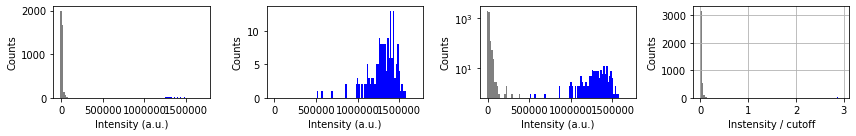

/Users/acoulon/CoulonLab/data/Maciej/2020/20201102_beads/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1/out/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1_AF488.loc


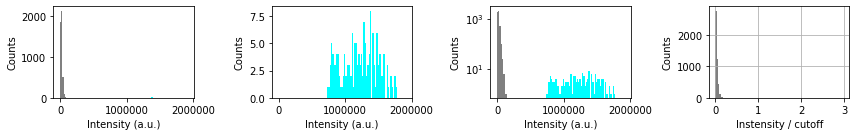

/Users/acoulon/CoulonLab/data/Maciej/2020/20201102_beads/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1/out/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1_Q570.loc


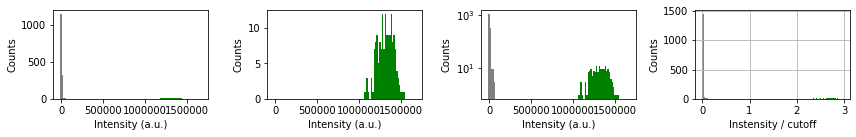

/Users/acoulon/CoulonLab/data/Maciej/2020/20201102_beads/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1/out/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1_CAL610.loc


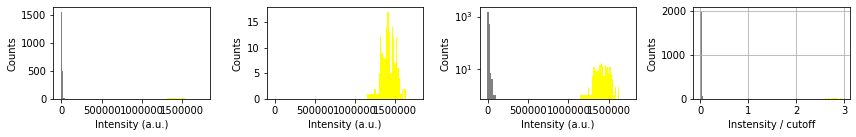

/Users/acoulon/CoulonLab/data/Maciej/2020/20201102_beads/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1/out/20201102_TetraSpecBeads-1uM_Q670-10ms_CAL610-40ms_Q570-8ms_GFP-65ms_DAPI-35ms_1_Q670.loc


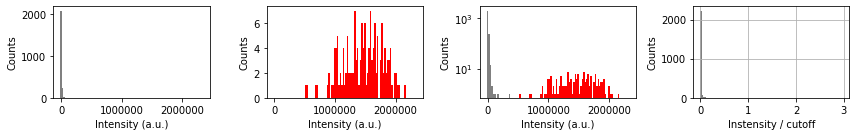

[]

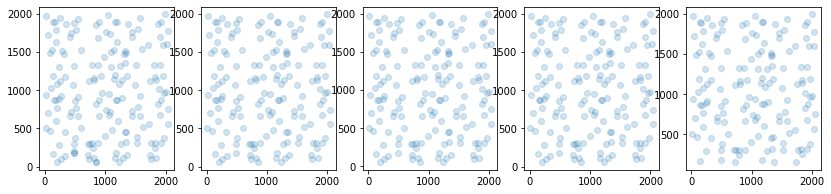

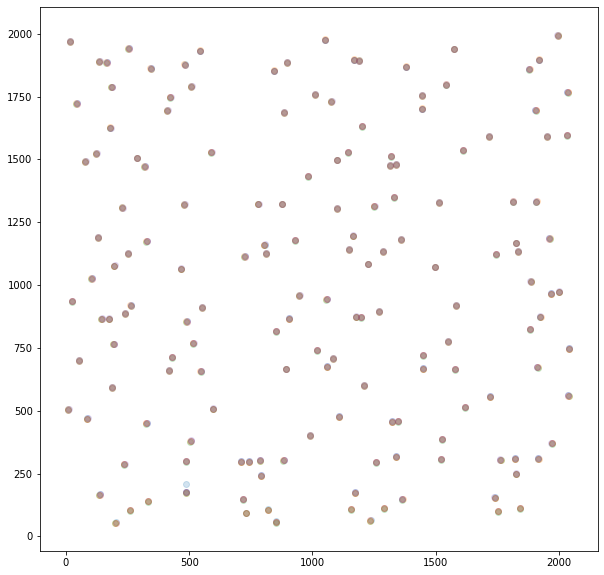

In [98]:
d_DAPI  =lf.loadLoc2(dirOut+dataSetName+'_DAPI.loc',  cutoffLow=5e5,disp=1,color='blue')
d_AF488 =lf.loadLoc2(dirOut+dataSetName+'_AF488.loc', cutoffLow=5e5,disp=1,color='cyan')
d_Q570  =lf.loadLoc2(dirOut+dataSetName+'_Q570.loc',  cutoffLow=5e5,disp=1,color='green')
d_CAL610=lf.loadLoc2(dirOut+dataSetName+'_CAL610.loc',cutoffLow=5e5,disp=1,color='yellow')
d_Q670  =lf.loadLoc2(dirOut+dataSetName+'_Q670.loc',  cutoffLow=5e5,disp=1,color='red')

fig,ax=plt.subplots(1,5,figsize=(14,3))
d=d_DAPI;   plt.sca(ax[0]); plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_AF488;  plt.sca(ax[1]); plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_Q570;   plt.sca(ax[2]); plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_CAL610; plt.sca(ax[3]); plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_Q670;   plt.sca(ax[4]); plt.scatter(d[:,1],d[:,2],alpha=.2)
plt.plot()

plt.figure(figsize=(10,10))
d=d_DAPI;   plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_AF488;  plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_Q570;   plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_CAL610; plt.scatter(d[:,1],d[:,2],alpha=.2)
d=d_Q670;   plt.scatter(d[:,1],d[:,2],alpha=.2)
plt.plot()